In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from math import sqrt
from sklearn.cluster import KMeans
from sklearn import datasets, preprocessing, model_selection

# Загрузка датасета

In [ ]:
def load_dataset():
    x, y = datasets.load_breast_cancer(return_X_y=True)
    x = preprocessing.scale(x)
    y = y.reshape(len(y), 1)

    x = x[:, :-20]  # убираем последние 10 столбцов
    return x, y

# Модель ИНС с одним скрытым слоем

In [ ]:
class NN():

  def __init__(self, input_size, hidden_size, output_size):
    # инициализация весов и смещений скрытого и выходного слоя
    self.w1 = np.random.rand(input_size, hidden_size)
    self.w2 = np.random.rand(hidden_size, output_size)
    self.b1 = np.random.rand(hidden_size)
    self.b2 = np.random.rand(output_size)

    self.metric = None

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  def sigmoid_derivative(self, x):
    return x * (1 - x)

  def relu(self, x):
    return np.maximum(0, x)

  def relu_derivative(self, x):
    return np.where(x > 0, 1, 0)

  def forward(self, input):
    out = np.matmul(input, self.w1) + self.b1
    return self.relu(out)

  def train(self, inputs, outputs, epochs, lr, penalty=0):

    self.metric = np.inf * np.ones(epochs)

    for epoch in range(epochs):
      # Прямое распространение
      hidden_input = np.matmul(inputs, self.w1) + self.b1
      hidden_output = self.relu(hidden_input)
      final_input = np.matmul(hidden_output, self.w2) + self.b2
      final_output = self.sigmoid(final_input)

      # Вычисление ошибок
      output_error = outputs - final_output
      output_error -= penalty
      hidden_error = np.matmul(output_error, self.w2.T) * self.relu_derivative(hidden_input)

      # Обновление весов и смещений
      self.w2 += lr * np.matmul(hidden_output.T, output_error)
      self.b2 += lr * np.sum(output_error, axis=0)
      self.w1 += lr * np.matmul(inputs.T, hidden_error)
      self.b1 += lr * np.sum(hidden_error, axis=0)
      self.metric[epoch] = np.sqrt(np.mean((outputs - final_output) ** 2))

      #if (epoch % 100) == 0:
      #  print('epoch = ', epoch, '  RMSE = ', self.metric[epoch])

  def predict(self, input):
    hidden_input = np.matmul(input, self.w1) + self.b1
    hidden_output = self.relu(hidden_input)
    final_input = np.matmul(hidden_output, self.w2) + self.b2
    final_output = self.sigmoid(final_input)
    return final_output

# NCL

In [ ]:
class NCL():

  def __init__(self, input_size, hidden_size, output_size, M):
    self.M = M  # Кол-во сетей в ансамбле
    self.metric = None
    self.ensamble_nn = [NN(input_size, hidden_size, output_size) for i in range(M)]

  def train(self, inputs, outputs, epochs, generations, lr, lambda_):

    self.metric = np.inf * np.ones(epochs)

    for generation in range(generations):
      preds = self.predict(inputs)
      for i in range(self.M):
        penalty = lambda_ *(self.ensamble_nn[i].predict(inputs) - preds)

        self.ensamble_nn[i].train(inputs, outputs, generations, lr, penalty)

      self.metric[generation] = np.sqrt(np.mean((outputs - preds) ** 2))

      if (generation % 10) == 0:
        print('epoch = ', generation, '  RMSE = ', self.metric[generation])

  def predict(self, x, method='mean'):
    if method == 'mean':
      return np.mean([nn.predict(x) for nn in self.ensamble_nn], axis=0)
    elif method == 'wta':
      predictions = np.array([nn.predict(x) for nn in self.ensamble_nn])
      return predictions[np.argmax(predictions, axis=0), np.arange(len(x))]
    else:
      raise ValueError("Invalid method. Choose either 'mean' or 'wta'.")

  def save_model(self, file_path):
    with open(file_path, 'wb') as f:
      pickle.dump(self, f)

  @staticmethod
  def load_model(file_path):
    with open(file_path, 'rb') as f:
      return pickle.load(f)

In [ ]:
x, y = load_dataset()
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size= 0.1, random_state=0)

input_size = x_train.shape[1] # Кол-в входных признаков
hidden_size = 5               # Кол-во нейронов на скрытом слое
output_size = 1               # Кол-во выходных нейронов
generations = 50              # Кол-во итераций для обучения ансамбля
epochs = 500                  # Кол-во эпох для обучение ИНС
lr = 0.001                    # Скорость обучения
lambda_ = 1                   # Параметр регулирующий влияние штрафа при обучении
M = 6                         # Кол-во ИНС в ансамбле

# Создание модели NCL
ncl1 = NCL(input_size, hidden_size, output_size, M)
ncl2 = NCL(input_size, hidden_size, output_size, M)

# Обучение NCL
ncl1.train(x_train, y_train, epochs, generations, lr, 0)
ncl2.train(x_train, y_train, epochs, generations, lr, 1)

# Сохранение моделей
ncl1.save_model('ncl1_ensemble.pkl')
ncl2.save_model('ncl2_ensemble.pkl')

epoch =  0   RMSE =  0.641462701451281
epoch =  10   RMSE =  0.1886147942835293
epoch =  20   RMSE =  0.17470082684732527
epoch =  30   RMSE =  0.16586362366843807
epoch =  40   RMSE =  0.15661587894862278
epoch =  0   RMSE =  0.6463827999219415
epoch =  10   RMSE =  0.1929480482338195
epoch =  20   RMSE =  0.1743947890572493
epoch =  30   RMSE =  0.16216863774254503
epoch =  40   RMSE =  0.15426765675100626


In [ ]:
print(x_test.shape)
pred1_wta  = ncl1.predict(x_test, 'wta')
pred1_mean = ncl1.predict(x_test, 'mean')
pred2_wta = ncl2.predict(x_test, 'wta')
pred2_mean = ncl2.predict(x_test, 'mean')

ncl1_wta_rmse  = np.sqrt(np.mean((y_test - pred1_wta) ** 2))
ncl1_mean_rmse = np.sqrt(np.mean((y_test - pred1_mean) ** 2))
ncl2_wta_rmse  = np.sqrt(np.mean((y_test - pred2_wta ) ** 2))
ncl2_mean_rmse = np.sqrt(np.mean((y_test - pred2_mean) ** 2))

print('WTA  RMSE lambda = 0:', ncl1_wta_rmse)
print('Mean RMSE lambda = 0:', ncl1_mean_rmse)
print('\n')
print('WTA  RMSE lambda = 1:', ncl2_wta_rmse)
print('Mean RMSE lambda = 1:', ncl2_mean_rmse)

(57, 10)
WTA  RMSE lambda = 0: 0.20383877983772164
Mean RMSE lambda = 0: 0.18813874636171826


WTA  RMSE lambda = 1: 0.17342552725505653
Mean RMSE lambda = 1: 0.17379233798441748


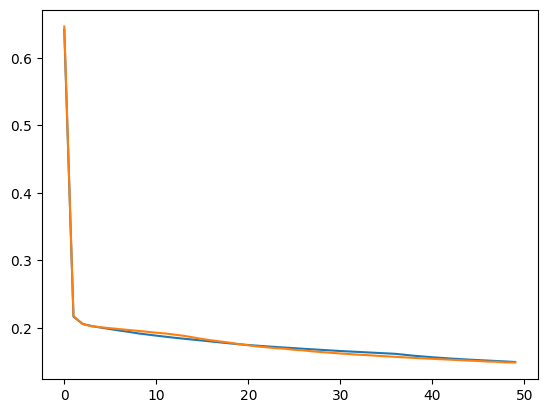

In [ ]:
plt.plot(ncl1.metric)
plt.plot(ncl2.metric)

# EENCL

In [ ]:
class EENCL():

  def __init__(self, input_size, hidden_size, output_size, M):
    self.population_size = M
    self.metric = None
    self.population = [NN(input_size, hidden_size, output_size) for i in range(M)]

  def combine_average(self, ensemble, inputs):
    # Комбинирование прогнозов нейронных сетей в ансамбле с помощью усреднения.
    predictions = np.array([nn.predict(inputs) for nn in ensemble])
    return np.mean(predictions, axis=0)

  def combine_voting(self, ensemble, inputs):
    # Комбинирование прогнозов нейронных сетей в ансамбле с помощью голосования.
    predictions = np.array([nn.predict(inputs) for nn in ensemble])
    return np.argmax(np.sum(predictions, axis=0), axis=1)

  def combine_wta(self, ensemble, inputs):
    # Комбинирование прогнозов нейронных сетей в ансамбле с помощью метода Winner-Takes-All (WTA)
    predictions = np.array([nn.predict(inputs) for nn in ensemble])
    return np.argmax(np.max(predictions, axis=0), axis=1)

  def form_ensemble(self, population, species):
    # Формирование ансамбля нейронных сетей на основе кластеризации.
    ensemble = []
    unique_species = np.unique(species)
    for species_id in unique_species:
        members = [population[i] for i, s in enumerate(species) if s == species_id]
        ensemble.append(members)
    return ensemble

  def evaluate_population(self, population, inputs, outputs):
    # Оценка качества нейронных сетей в популяции
    fitness_scores = []
    for nn in population:
        predictions = nn.predict(inputs)
        rmse = np.sqrt(np.mean((outputs - predictions) ** 2))
        fitness_scores.append(rmse)
    return fitness_scores

  def select_parents(self, population, fitness_scores, num_parents):
    # Выбор родителей для размножения на основе их качества
    selected_indices = np.argsort(fitness_scores)[:num_parents]
    return [population[i] for i in selected_indices]

  def crossover(self, parent1, parent2):
    # Кроссинговер родителей для создания потомка
    child = NN(parent1.w1.shape[0], parent1.w1.shape[1], parent1.w2.shape[1])
    child.w1 = (parent1.w1 + parent2.w1) / 2
    child.w2 = (parent1.w2 + parent2.w2) / 2
    child.b1 = (parent1.b1 + parent2.b1) / 2
    child.b2 = (parent1.b2 + parent2.b2) / 2
    return child

  def generate_offspring(self, parents, num_offspring):
    # Генерация потомков на основе выбранных родителей
    offspring = []
    for i in range(num_offspring):
      parent1, parent2 = np.random.choice(parents, 2, replace=False)
      child = self.crossover(parent1, parent2)
      offspring.append(child)
    return offspring

  def mutate(self, population, mutation_rate):
    # Мутация популяции нейронных сетей
    for nn in population:
      for layer in [nn.w1, nn.w2, nn.b1, nn.b2]:
        layer += np.random.normal(scale=mutation_rate, size=layer.shape)

  def train(self, inputs, outputs, epochs, generations, lr, num_parents, num_offspring, mr):
    # Обучение ансамбля эволюционных нейронных сетей.
    self.metric = np.inf * np.ones(generations)

    for generation in range(generations):

      # Обучение всей популяции
      for nn in self.population:
        nn.train(inputs, outputs, epochs, lr, 0)

      # Оценка текущей популяции
      fitness_scores = self.evaluate_population(self.population, inputs, outputs)
      self.metric[generation] = np.mean(fitness_scores)
      print(f'Generation {generation}: RMSE = {self.metric[generation]}')

      # Выбор родителей
      parents = self.select_parents(self.population, fitness_scores, num_parents)

      # Генерация потомков
      offspring = self.generate_offspring(parents, num_offspring)

      # Мутация
      self.mutate(offspring, mr)

      # Обучение потомков
      for child in offspring:
        child.train(inputs, outputs, epochs, lr)

      # Обновление популяции потомками
      self.population.extend(offspring)
      fitness_scores = self.evaluate_population(self.population, inputs, outputs)
      selected_indices = np.argsort(fitness_scores)[:self.population_size]
      self.population = [self.population[idx] for idx in selected_indices]

    final_fitness_scores = self.evaluate_population(self.population, inputs, outputs)
    final_fitness_scores = np.array(final_fitness_scores).reshape(-1, 1)

    # Разделение на 3 кластера
    kmeans = KMeans(n_clusters=3)
    species = kmeans.fit_predict(final_fitness_scores)

    # Формирование ансамбля
    ensemble = self.form_ensemble(self.population, species)

    return self.population, species

  def save_model(self, file_path):
    # Сохранения модели
    with open(file_path, 'wb') as f:
      pickle.dump(self, f)

  def load_model(self, file_path):
    # Загрузка модели
    with open(file_path, 'rb') as f:
      return pickle.load(f)


In [ ]:
x, y = load_dataset()
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size= 0.1, random_state=0)

input_size = x_train.shape[1] # Кол-в входных признаков
hidden_size = 5               # Кол-во нейронов на скрытом слое
output_size = 1               # Кол-во выходных нейронов
generations = 50              # Кол-во итераций для обучения ансамбля
epochs = 500                  # Кол-во эпох для обучение ИНС
M = 6                         # Кол-во ИНС в ансамбле
lr = 0.001                    # Скорость обучения
mr = 0.01                     # Скорость мутации
num_parents = 4               # Кол-во родителей, которые породят следующую популяцию
num_offspring = 4             # Кол-во потомков

eencl = EENCL(input_size, hidden_size, output_size, M)
ensemble, species  = eencl.train(x_train, y_train, epochs, generations, lr, num_parents, num_offspring, mr)

# Сохраняем модель
eencl.save_model('eencl_ensemble.pkl')

Generation 0: RMSE = 0.1915761352614529
Generation 1: RMSE = 0.15483748730736432
Generation 2: RMSE = 0.1382438332057819
Generation 3: RMSE = 0.12737166788732143
Generation 4: RMSE = 0.11624183609535578
Generation 5: RMSE = 0.1109782480348858
Generation 6: RMSE = 0.10773413818546518
Generation 7: RMSE = 0.10489628054699802
Generation 8: RMSE = 0.10228555095610943
Generation 9: RMSE = 0.10037749162024712
Generation 10: RMSE = 0.0974050092402804
Generation 11: RMSE = 0.09305102402009828
Generation 12: RMSE = 0.08924175214255319
Generation 13: RMSE = 0.08619768824913293
Generation 14: RMSE = 0.08356933522792254
Generation 15: RMSE = 0.08107683274301394
Generation 16: RMSE = 0.07866916939011649
Generation 17: RMSE = 0.07560757199684127
Generation 18: RMSE = 0.07350667925659687
Generation 19: RMSE = 0.07163463251762346
Generation 20: RMSE = 0.07002518247982559
Generation 21: RMSE = 0.06847960542277685
Generation 22: RMSE = 0.06702515523363156
Generation 23: RMSE = 0.06571904919596568
Genera

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
final_ensemble = eencl.form_ensemble(ensemble, species)

# Объединяем все ИНС из final_ensemble в один список
all_nns = [nn for sublist in final_ensemble for nn in sublist]

# Комбинируем ИНС внутри ансамбля с помощью различных методов
average_predictions = eencl.combine_average(all_nns, x_test)
voting_predictions = eencl.combine_voting(all_nns, x_test)
wta_predictions = eencl.combine_wta(all_nns, x_test)

# Оцениваем прогнозы с использованием метрики качества (например, RMSE)
rmse_average = np.sqrt(np.mean((y_test - average_predictions) ** 2))
rmse_voting = np.sqrt(np.mean((y_test - voting_predictions) ** 2))
rmse_wta = np.sqrt(np.mean((y_test - wta_predictions) ** 2))

print('RMSE для усреднения:', rmse_average)
print('RMSE для голосования:', rmse_voting)
print('RMSE для WTA:', rmse_wta)


RMSE для усреднения: 0.18431741841948807
RMSE для голосования: 0.7836039099693788
RMSE для WTA: 0.7836039099693788


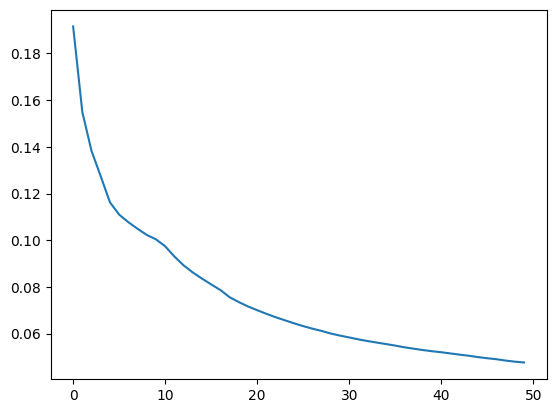

In [ ]:
plt.plot(eencl.metric)

# Print network

In [ ]:
import networkx as nx
def plot_nn_graph(ax, nn, subplot_title, inputs):
    G = nx.DiGraph()

    input_size = nn.w1.shape[0]
    hidden_size = nn.w1.shape[1]
    output_size = nn.w2.shape[1]

    hidden_output = nn.forward(inputs)
    final_output  = nn.predict(inputs)

    input_nodes  = [f'I{i}:{round(inputs[i], 2)}' for i in range(input_size)]
    hidden_nodes = [f'H{i}:{round(hidden_output[i], 2)}' for i in range(hidden_size)]
    output_nodes = [f'O{i}:{round(final_output[i], 2)}' for i in range(output_size)]

    G.add_nodes_from(input_nodes, layer='input')
    G.add_nodes_from(hidden_nodes, layer='hidden')
    G.add_nodes_from(output_nodes, layer='output')

    for i in range(input_size):
        for j in range(hidden_size):
            G.add_edge(input_nodes[i], hidden_nodes[j], weight=nn.w1[i, j])

    for i in range(hidden_size):
        for j in range(output_size):
            G.add_edge(hidden_nodes[i], output_nodes[j], weight=nn.w2[i, j])

    def get_layer_pos(layer_nodes, layer_index, total_layers):
        layer_size = len(layer_nodes)
        y_gap = 2
        y_start = -(layer_size - 1) * y_gap / 2
        x_pos = layer_index * 0.1  # уменьшить расстояние между слоями
        return {node: (x_pos, y_start + i * y_gap) for i, node in enumerate(layer_nodes)}

    pos = {}
    pos.update(get_layer_pos(input_nodes, 0, 3))
    pos.update(get_layer_pos(hidden_nodes, 1, 3))
    pos.update(get_layer_pos(output_nodes, 2, 3))

    edge_colors = ['red' if d['weight'] > 1 else 'grey' for u, v, d in G.edges(data=True)]

    plt.figure(figsize=(8, 6))

    nx.draw(G, pos, with_labels=True, node_size=1200, node_color="skyblue", font_size=8, font_weight="bold", arrows=True, edge_color=edge_colors, ax=ax)
    ax.set_title(subplot_title)

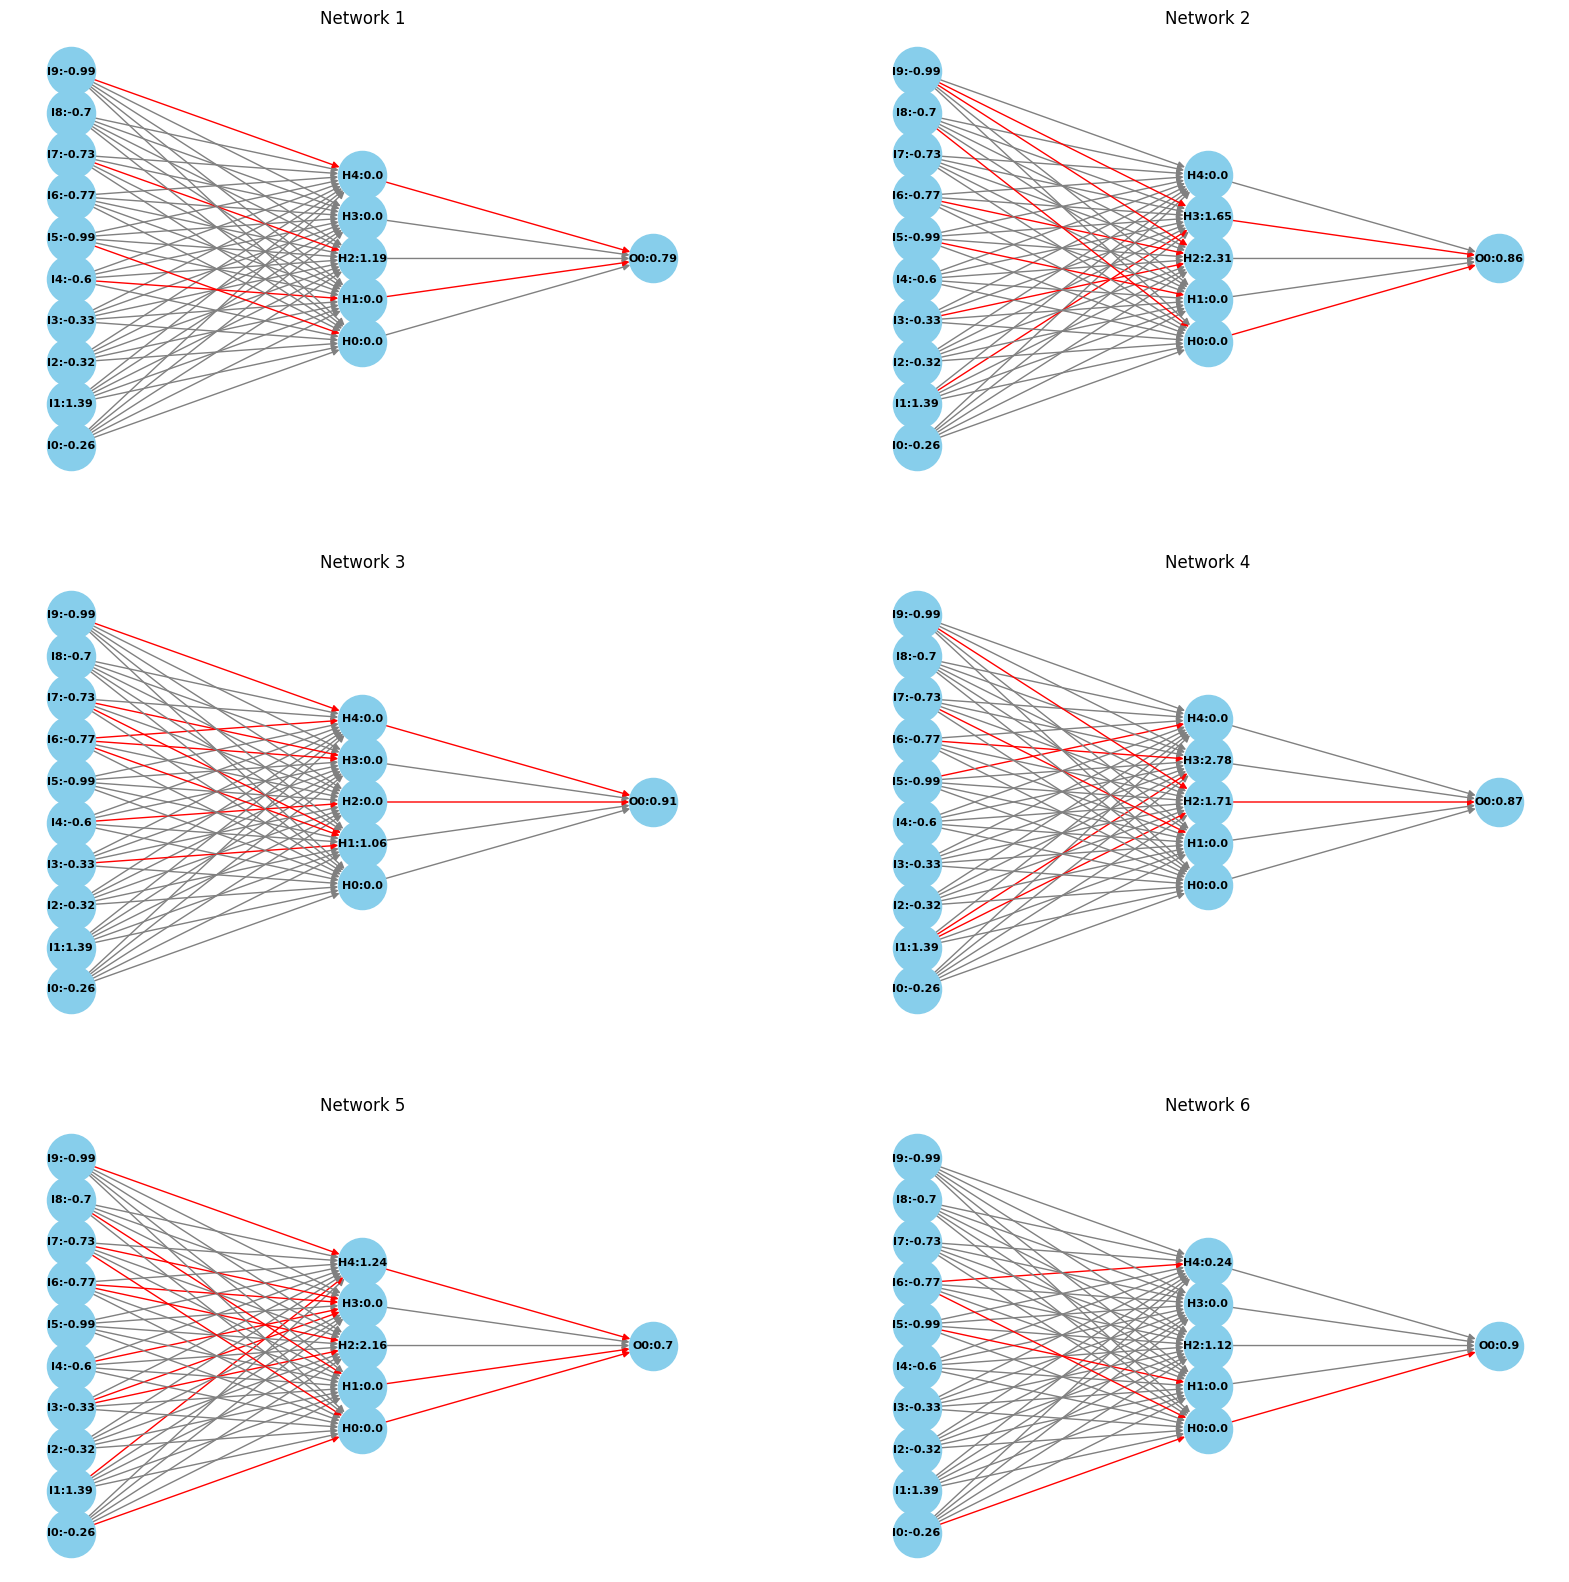

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [ ]:
# NCL
nns = ncl2.ensamble_nn
#ensamble_nn
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for i, (ax, nn) in enumerate(zip(axes.flatten(), nns)):
    plot_nn_graph(ax, nn, f'Network {i+1}', x_test[1])

plt.tight_layout()
plt.show()

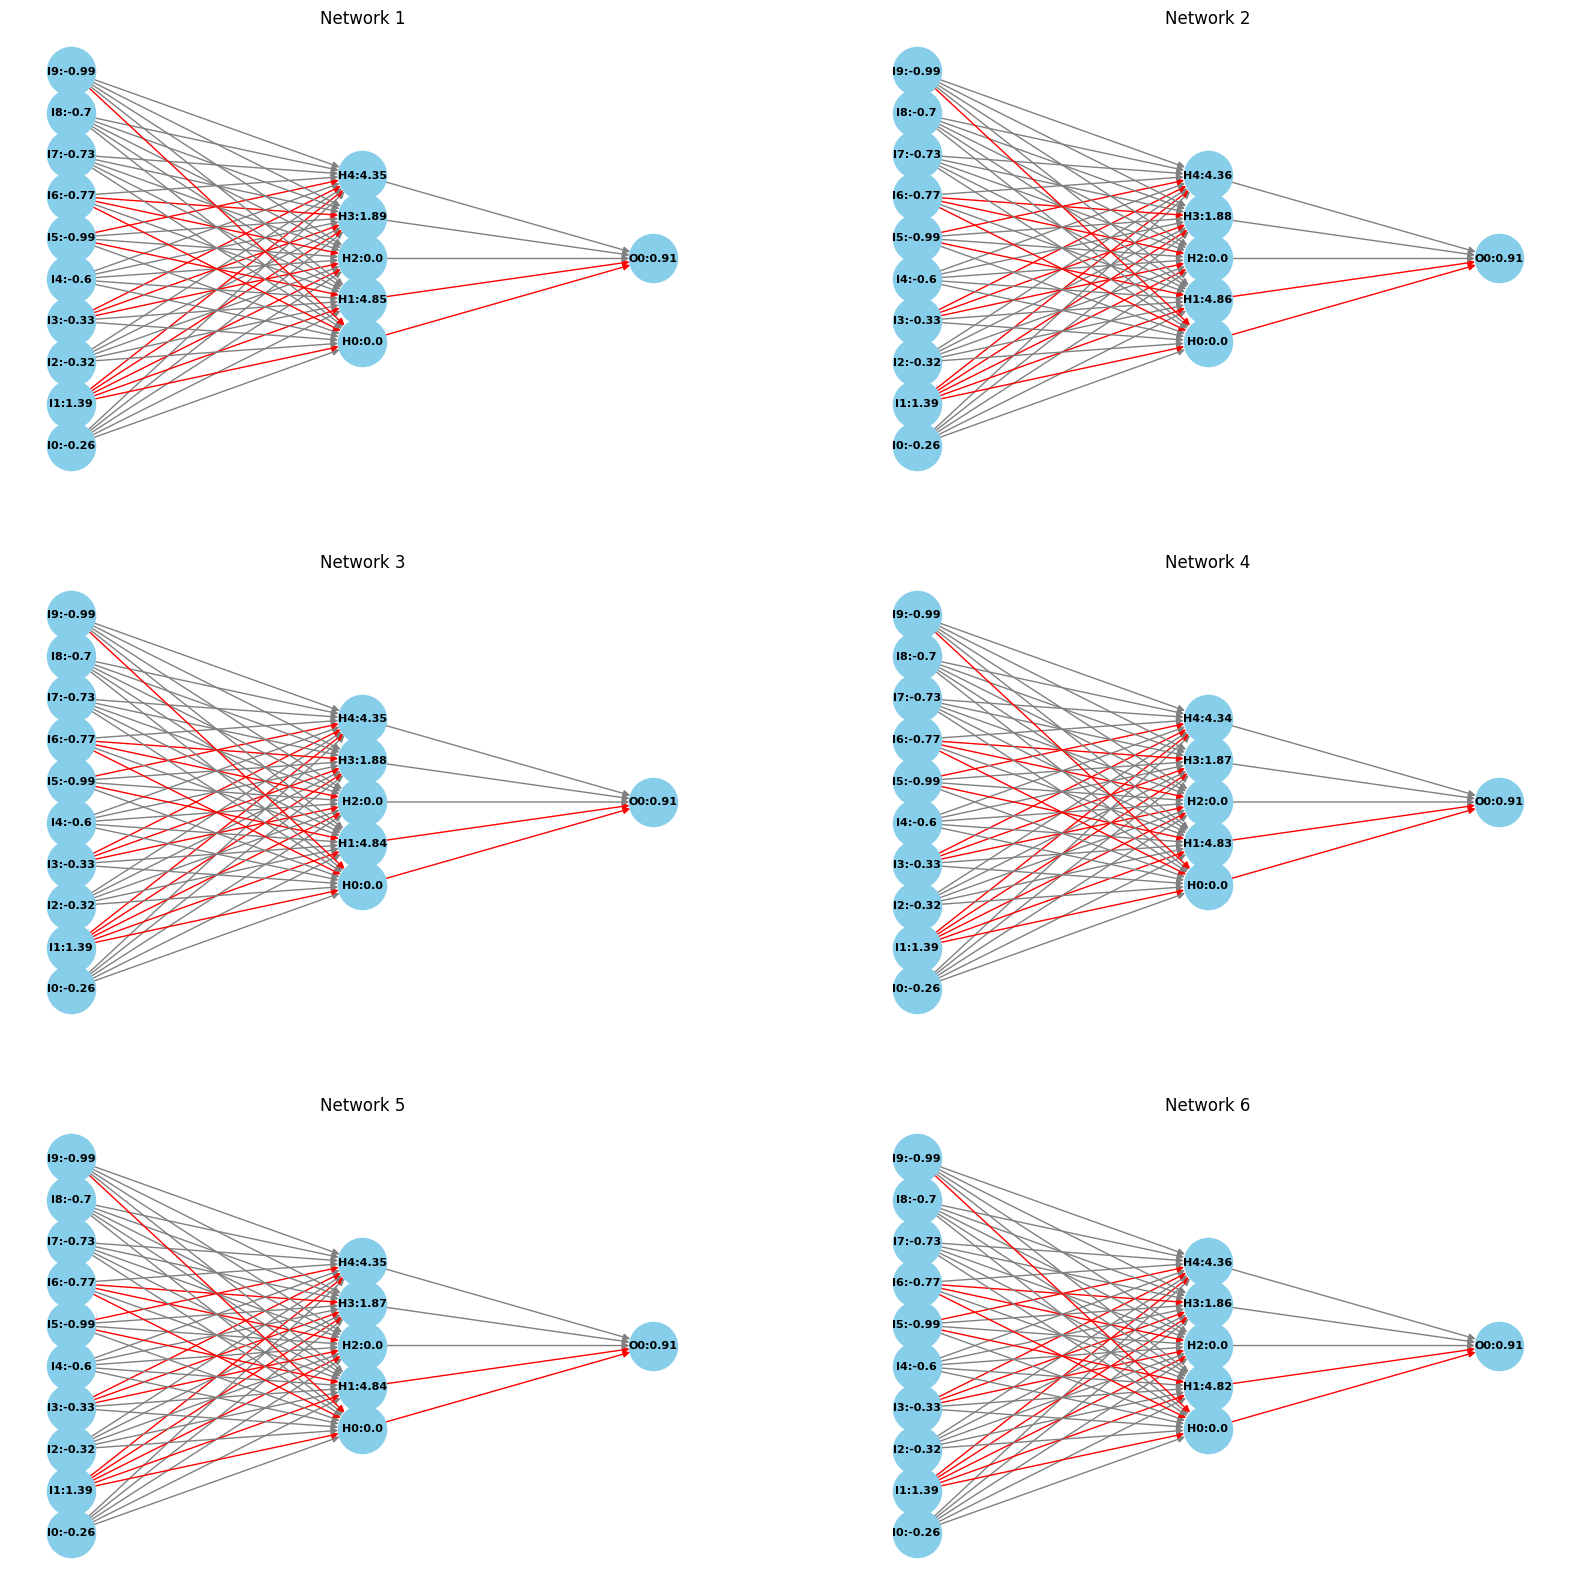

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [ ]:
# EENCL
nns = eencl.population
#ensamble_nn
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for i, (ax, nn) in enumerate(zip(axes.flatten(), nns)):
    plot_nn_graph(ax, nn, f'Network {i+1}', x_test[1])

plt.tight_layout()
plt.show()

# Load models

In [ ]:
# Загрузка моделей
loaded_ncl = NCL.load_model('ncl2_ensemble.pkl')
loaded_eencl = NCL.load_model('eencl_ensemble.pkl')

# Оценка
pred1 = loaded_ncl.predict(x_test)
pred2 = eencl.combine_average(loaded_eencl.population, x_test)

rmse_value = np.sqrt(np.mean((y_test - pred1) ** 2))
rmse_average = np.sqrt(np.mean((y_test - pred2) ** 2))

print('EENCL RMSE :', rmse_average)
print('NCL RMSE   :', rmse_value)

EENCL RMSE : 0.18431741841948807
NCL RMSE   : 0.17379233798441748
